In [1]:
import arviz as az
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano.tensor as tt

In [2]:
%load_ext watermark
%matplotlib inline
%config Inline.figure_formats = ['retina']
az.style.use('arviz-darkgrid')

## Example. Estimating the risk of tumor in a group of rats

In [3]:
rat_tumor = np.loadtxt('data/rat_tumor_data.txt', skiprows=3)

In [4]:
# If you can use bash
!cat data/rat_tumor_data.txt | head

# Rat tumor data from Tarone (1982).  Data from Table 5.1 of Bayesian Data Analysis.

y N  
0 20 
0 20 
0 20 
0 20 
0 20 
0 20 
0 20 


As you can see, the first column of `rat_tumor` is $y$ and the second column is $N$.

In [5]:
print(f'The shape of rat_tumor is {rat_tumor.shape}')

The shape of rat_tumor is (71, 2)


We construct the model.

In [6]:
with pm.Model() as model_1:
    
    alpha = pm.Uniform('alpha', lower=0, upper=10)
    beta = pm.Uniform('beta', lower=0, upper=25)
        
    theta = pm.Beta('theta', alpha, beta, shape=rat_tumor.shape[0])
    
    y = pm.Binomial('y', n=rat_tumor[:, 1], p=theta, observed=rat_tumor[:, 0])

In [7]:
model_1.check_test_point()

alpha_interval__     -1.39
beta_interval__      -1.39
theta_logodds__     -21.37
y                  -256.01
Name: Log-probability of test_point, dtype: float64

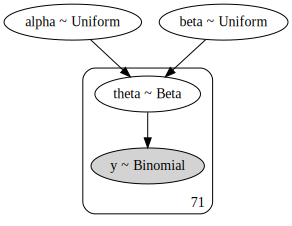

In [8]:
display(pm.model_to_graphviz(model_1))

In [9]:
with model_1:
    trace_1 = pm.sample(draws=5_000, tune=10_000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, beta, alpha]


Sampling 4 chains for 10_000 tune and 5_000 draw iterations (40_000 + 20_000 draws total) took 42 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6981318848403713, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


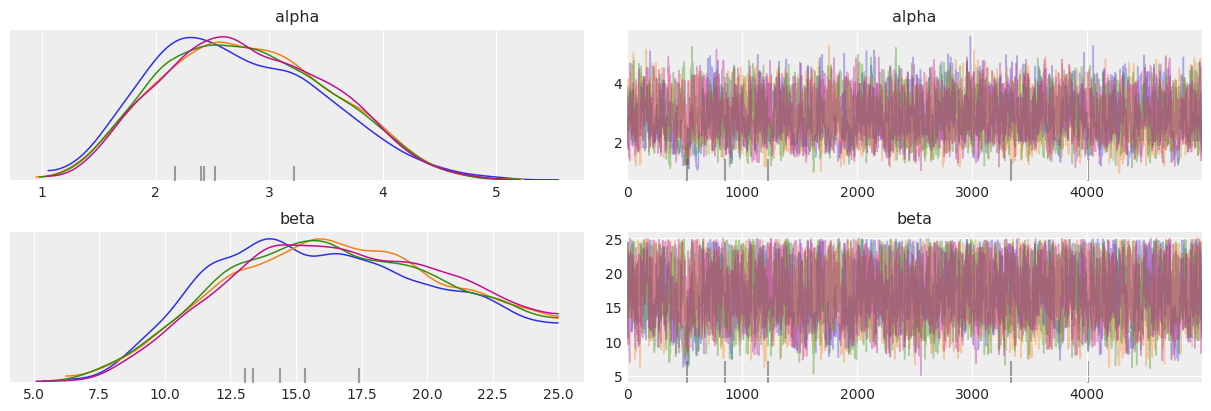

In [10]:
az.plot_trace(trace_1, var_names=['alpha', 'beta']);

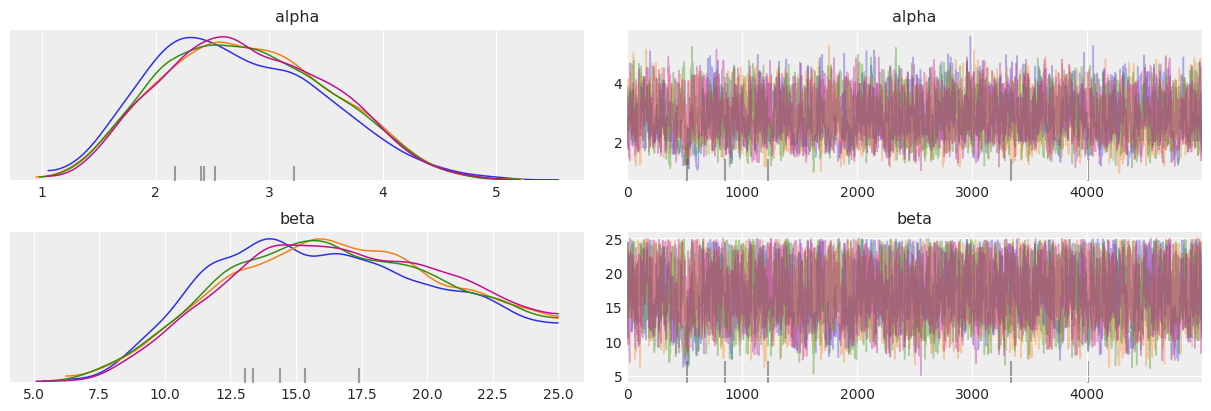

In [11]:
# Negation is another form of variable selection
az.plot_trace(trace_1, var_names='~theta');

In [12]:
az.summary(trace_1, var_names=['alpha', 'beta'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,2.791,0.732,1.499,4.113,0.017,0.012,1848.0,1848.0,1708.0,2191.0,1.0
beta,16.735,4.189,10.106,24.725,0.093,0.066,2038.0,2038.0,2027.0,2755.0,1.0


The posterior plot of `alpha` and `beta`.

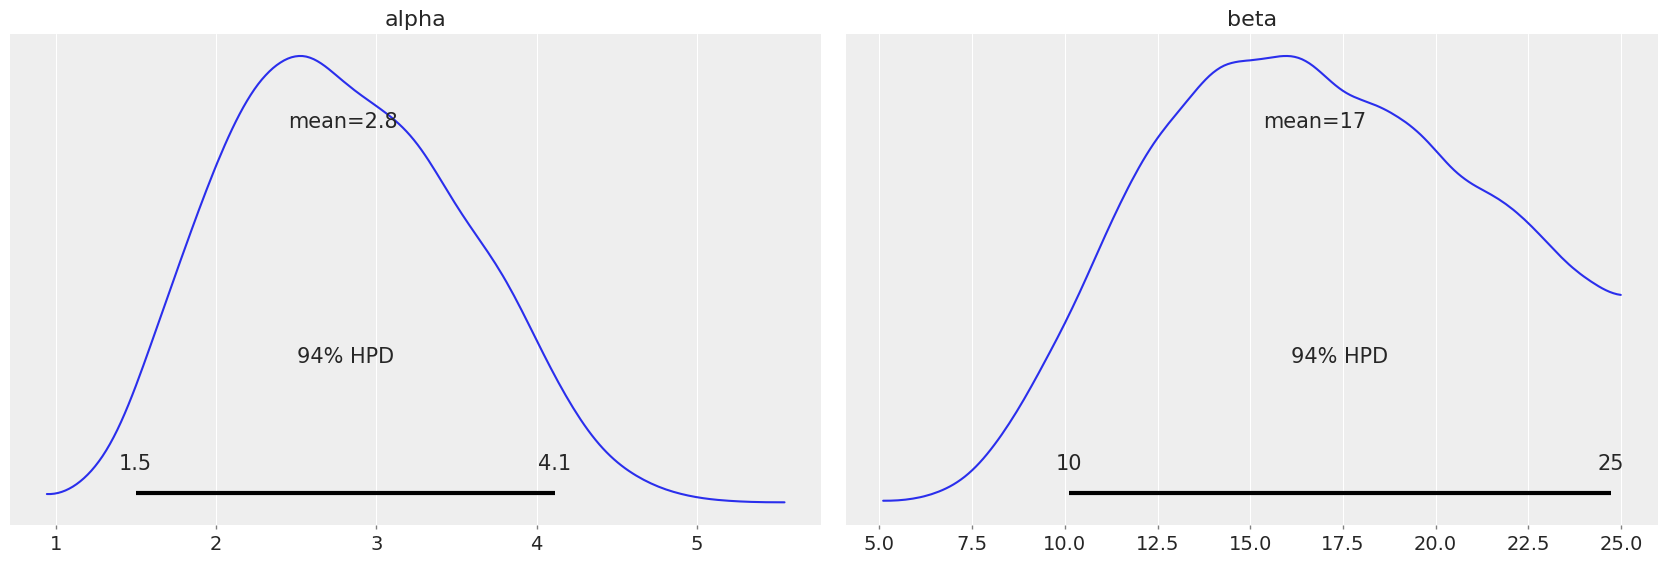

In [13]:
az.plot_posterior(trace_1, var_names=['alpha', 'beta']);

As you can see, I have used a uniform distribution for `alpha` and `beta`. You *could* say that it is a regular prior, not good, not bad, but at the end disappointing. So let's try to improve the priors. 

The following is taken from [here][1]. According to the book, the prior for $\alpha$ and $\beta$ is 

$$p(\alpha, \beta) \propto (\alpha + \beta) ^{-5/2}$$

In order to use this prior, you have to define the logarithm of $p(\alpha, \beta)$ and use it in `pm.Potential`, [look here][2]. 

[1]:https://github.com/pymc-devs/pymc3/blob/master/docs/source/notebooks/GLM-hierarchical-binominal-model.ipynb
[2]:https://discourse.pymc.io/t/difference-between-densitydist-and-potential/307/4

In [14]:
def logp_ab(value):
    """
    Prior density for this problem
    """
    return tt.log(tt.pow(tt.sum(value), -5/2))

with pm.Model() as model_10:
    # Proper noninformative prior for alpha and beta
    ab = pm.HalfFlat('ab', shape=2, testval=np.asarray([1., 1.]))
    pm.Potential('p(a, b)', logp_ab(ab))
    
    # Our alpha and beta
    alpha = pm.Deterministic('alpha', ab[0])
    beta = pm.Deterministic('beta', ab[1])
    
    theta = pm.Beta('theta', alpha=ab[0], beta=ab[1], shape=rat_tumor.shape[0])

    p = pm.Binomial('y', p=theta, observed=rat_tumor[:,0], n=rat_tumor[:,1])

In [15]:
with model_10:
    trace_10 = pm.sample(draws=5_000, tune=5_000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, ab]


Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 27 seconds.
There were 984 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6429178966263065, but should be close to 0.8. Try to increase the number of tuning steps.
There were 273 divergences after tuning. Increase `target_accept` or reparameterize.
There were 342 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


Unlike in the model with the uninformative, flat prior, this model gets many divergences.

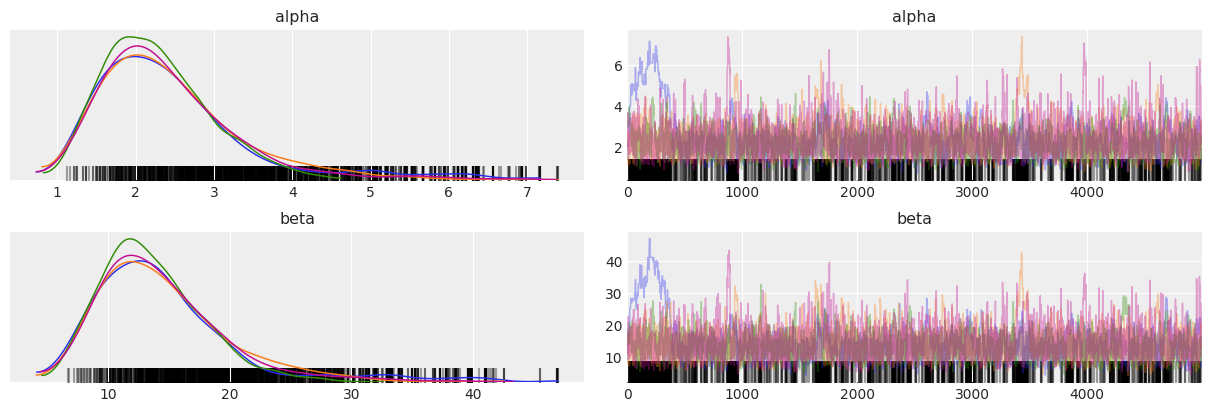

In [16]:
az.plot_trace(trace_10, var_names=['alpha', 'beta']);

In [17]:
az.summary(trace_10, var_names=['alpha', 'beta'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,2.401,0.893,1.063,4.010,0.060,0.050,222.0,158.0,483.0,136.0,1.01
beta,14.300,5.353,6.064,23.714,0.369,0.318,211.0,143.0,464.0,149.0,1.01


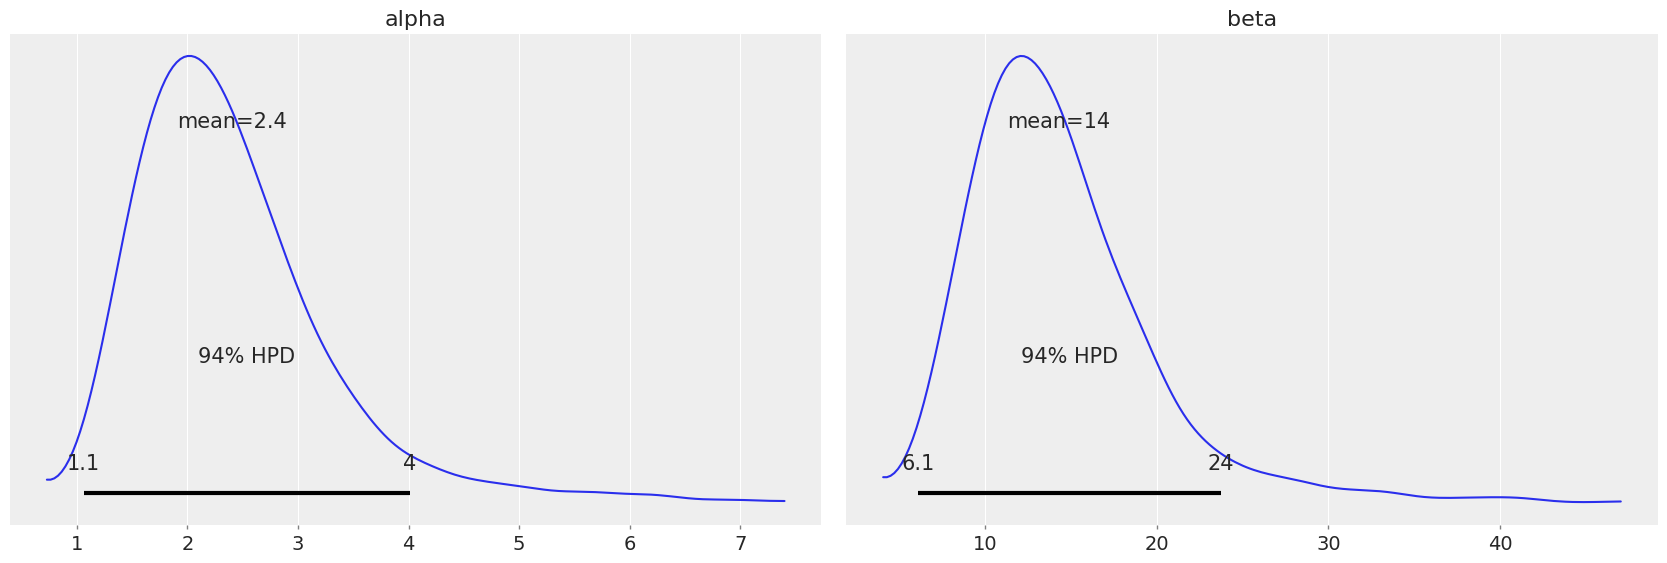

In [18]:
az.plot_posterior(trace_10, var_names=['alpha', 'beta']);

Better, don't you think? And they are closer to the value $(\alpha, \beta) = (2.4, 14.0)$ shown in the book.

The next plots are a contour plot and a scatter plot.

In [19]:
# Why do we plot only a subset of the α's and β's?

begi = 4_000

alpha_trunc = trace_10['alpha'][begi: begi + 1000] # in the original, alpha and beta were flipped.
beta_trunc = trace_10['beta'][begi: begi + 1000]

idata_10 = az.from_pymc3(trace_10, coords={'ab_index': ['alpha', 'beta'], 'experiments': range(71)}, dims={'ab': ['ab_index'], 'theta': ['experiments']})

In [20]:
idata_10.posterior['log(alpha / beta)'] = np.log(idata_10.posterior['alpha'] / idata_10.posterior['beta'])
idata_10.posterior['log(alpha + beta)'] = np.log(idata_10.posterior['alpha'] + idata_10.posterior['beta'])

In [21]:
idata_10.posterior

<xarray.Dataset>
Dimensions:            (ab_index: 2, chain: 4, draw: 5000, experiments: 71)
Coordinates:
  * chain              (chain) int64 0 1 2 3
  * draw               (draw) int64 0 1 2 3 4 5 ... 4995 4996 4997 4998 4999
  * ab_index           (ab_index) <U5 'alpha' 'beta'
  * experiments        (experiments) int64 0 1 2 3 4 5 6 ... 65 66 67 68 69 70
Data variables:
    ab                 (chain, draw, ab_index) float64 2.185 14.03 ... 12.22
    alpha              (chain, draw) float64 2.185 2.131 1.414 ... 3.38 2.542
    beta               (chain, draw) float64 14.03 10.83 9.885 ... 23.49 12.22
    theta              (chain, draw, experiments) float64 0.07841 ... 0.1611
    log(alpha / beta)  (chain, draw) float64 -1.86 -1.626 ... -1.939 -1.57
    log(alpha + beta)  (chain, draw) float64 2.786 2.562 2.425 ... 3.291 2.692
Attributes:
    created_at:                 2020-04-24T21:27:00.254444
    arviz_version:              0.7.0
    inference_library:          pymc3
    inference_library_version:  3.8

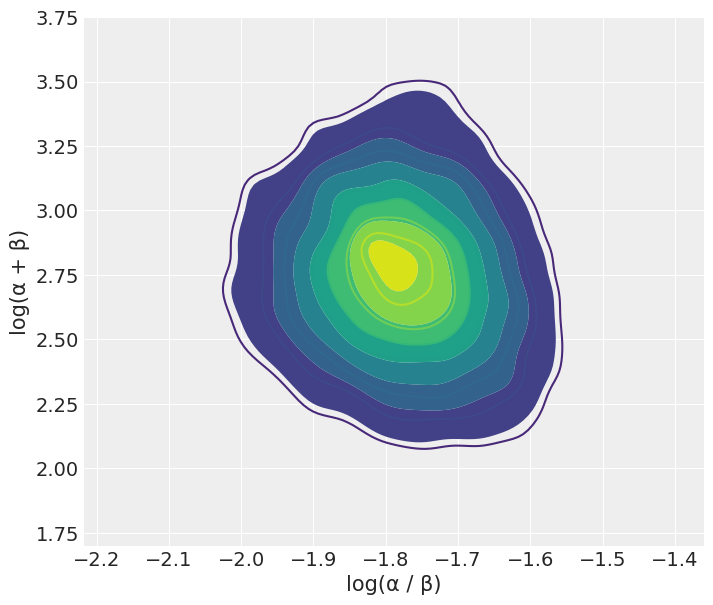

In [22]:
dfig, ax = plt.subplots(figsize=(8, 7))

az.plot_kde(values2=idata_10.posterior['log(alpha + beta)'], values=idata_10.posterior['log(alpha / beta)'], ax=ax,
            contour=True, fill_last=False,
            contour_kwargs={'levels': 10, 'colors': None, 'cmap': 'viridis'})
    
ax.grid()
ax.set_ylim(1.7, 3.75)
ax.set_xlabel('log(α / β)')
_ = ax.set_ylabel('log(α + β)')

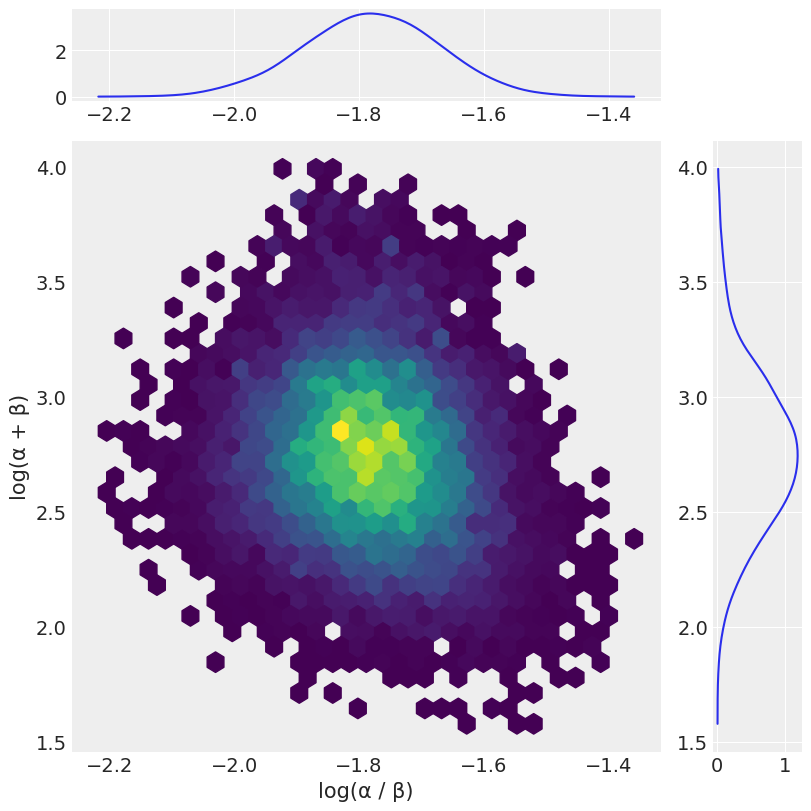

In [23]:
az.style.use("arviz-darkgrid")
widths = [2, 0.3]
heights = [0.3, 2]
gs_kw = dict(width_ratios=widths, height_ratios=heights)
fig, axes = plt.subplots(ncols=2, nrows=2, 
                         figsize=(8,8),
                         constrained_layout=True,
                         gridspec_kw=gs_kw)

az.plot_pair(idata_10, var_names=['log(alpha / beta)', 'log(alpha + beta)'], diagonal=True, colorbar=True, kind=['hexbin'], ax=axes) #, hexbin_kwargs={'cmap': 'viridis'})
axes[1, 0].set_xlabel('log(α / β)') 
axes[1, 0].set_ylabel('log(α + β)');
plt.show()
plt.close()

Now, we draw 1000 samples for `theta` from the posterior distribution.

In [24]:
post_theta = pm.fast_sample_posterior_predictive(trace_10, model=model_10, var_names=['theta'])

Posterior medians and 95% highest posterior density of rat tumor rates, $\theta_j$ (plotted vs. observed tumor rates $y_j / n_j$).

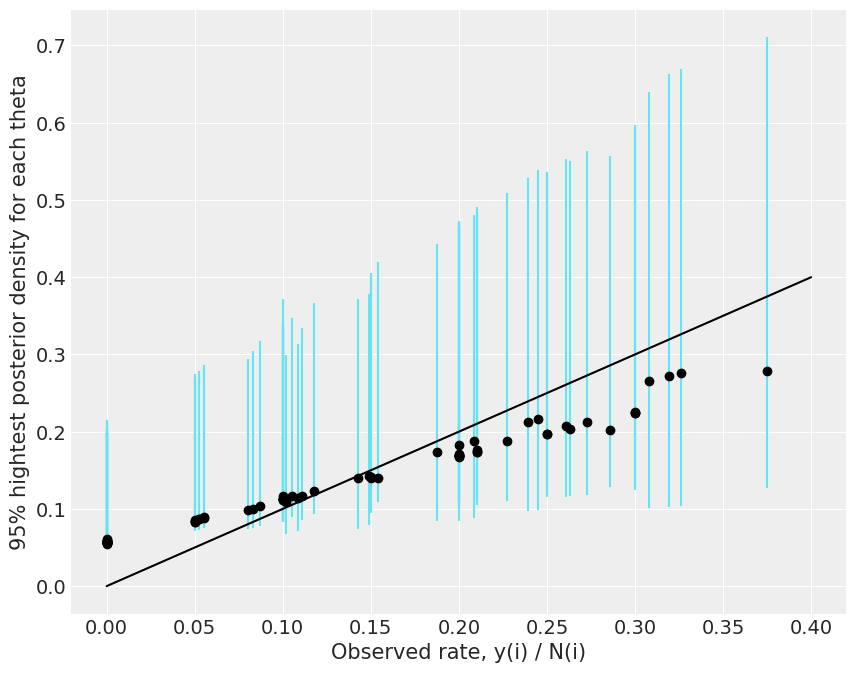

In [25]:
median_theta = np.median(post_theta['theta'], axis=0)
hpd_ = az.hpd(post_theta['theta'][None, :], credible_interval=0.95)

plt.figure(figsize=(10, 8))
plt.errorbar(rat_tumor[:, 0] / rat_tumor[:, 1], median_theta, fmt='o',
            yerr=[hpd_[:, 0], hpd_[:, 1]], ecolor='C5', markerfacecolor='k', mec='k',
            errorevery=1)
plt.plot(np.linspace(0, .4, 10), np.linspace(0, .4, 10), color='k')
plt.xlabel('Observed rate, y(i) / N(i)')
plt.ylabel('95% hightest posterior density for each theta');

## Example: parallel experiments in eight schools

Data of the eight schools model.

In [26]:
yy = np.array([28.,  8., -3.,  7., -1.,  1., 18., 12.])
sigma = np.array([15., 10., 16., 11.,  9., 11., 10., 18.])

In [27]:
with pm.Model() as model_2:
    mu = pm.Uniform('mu', lower=0, upper=30)
    tau = pm.Uniform('tau', lower=0, upper=30)
    theta = pm.Normal('theta', mu=mu, sd=tau, shape=yy.shape[0])
    obs = pm.Normal('obs', mu=theta, sd=sigma, observed=yy)

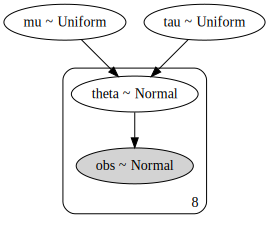

In [28]:
display(pm.model_to_graphviz(model_2))

In [29]:
with model_2:
    trace_2 = pm.sample(draws=15_000, tune=30_000, nuts_kwargs={'target_accept':0.99})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, tau, mu]


Sampling 4 chains for 30_000 tune and 15_000 draw iterations (120_000 + 60_000 draws total) took 498 seconds.
There were 274 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9566298007276023, but should be close to 0.99. Try to increase the number of tuning steps.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
There were 97 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


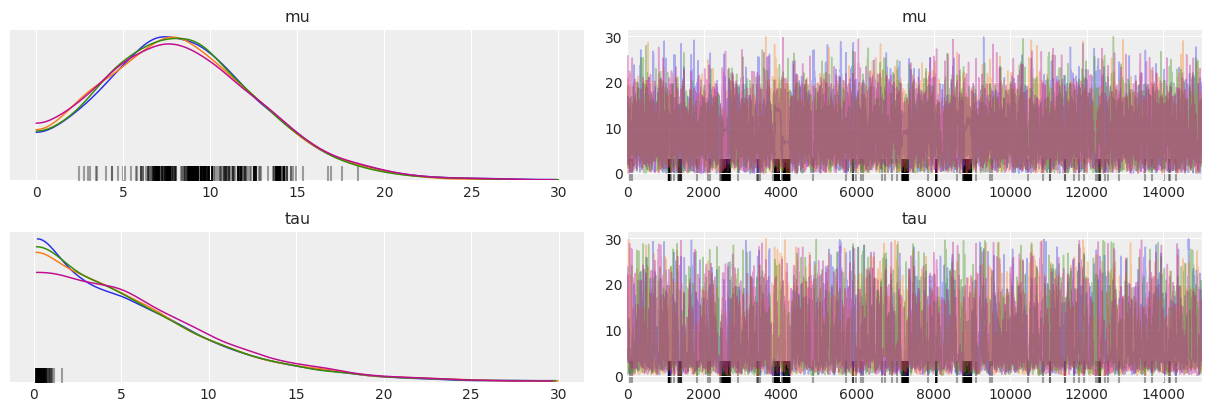

In [30]:
az.plot_trace(trace_2, var_names=['mu', 'tau']);

In [31]:
az.summary(trace_2)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
theta[0],11.674,8.120,-1.714,28.504,0.084,0.060,9249.0,9249.0,9433.0,19343.0,1.0
theta[1],8.216,6.054,-3.224,19.994,0.047,0.034,16854.0,16030.0,15586.0,25799.0,1.0
theta[2],6.632,7.432,-7.928,20.928,0.060,0.042,15383.0,15383.0,14148.0,20097.0,1.0
theta[3],7.976,6.294,-4.329,19.939,0.048,0.035,16968.0,16557.0,15360.0,25541.0,1.0
theta[4],5.533,6.162,-6.571,16.876,0.066,0.047,8661.0,8661.0,8305.0,16050.0,1.0
theta[5],6.548,6.517,-6.485,18.614,0.055,0.039,13879.0,13879.0,13187.0,21800.0,1.0
theta[6],10.907,6.591,-0.662,23.843,0.068,0.048,9503.0,9503.0,9256.0,21090.0,1.0
theta[7],8.874,7.578,-5.896,23.558,0.053,0.043,20514.0,15591.0,17431.0,22875.0,1.0
mu,8.502,4.548,0.004,15.948,0.047,0.033,9290.0,9290.0,8626.0,10253.0,1.0
tau,6.306,5.154,0.152,15.769,0.103,0.073,2487.0,2487.0,1204.0,661.0,1.0


The posterior plot of `tau`

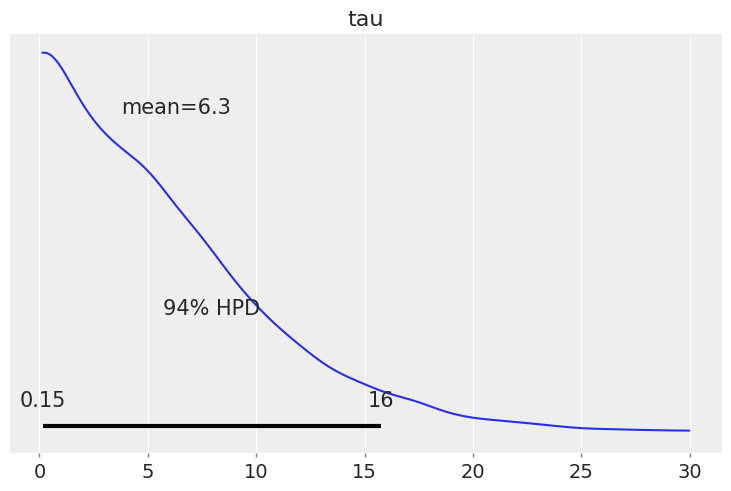

In [32]:
az.plot_posterior(trace_2, var_names=['tau']);

We draw 1000 samples of `tau` and `theta` from the posterior distribution.

In [33]:
with model_2:
    post_trace_sample = pm.fast_sample_posterior_predictive(trace_2, samples=1_000, var_names=['tau', 'theta'])

/Users/rpg/src/pymc3/pymc3/distributions/posterior_predictive.py:203: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn("samples parameter is smaller than nchains times ndraws, some draws "


In [34]:
def partition_mean(ll, part):
    """
    It takes two arguments, a list of pairs of points, (x, y), and the 
    length of the partition. It returns two lists, the first is a 
    list of means for each partiton on x and the second is a list of means
    for each partition on y.
    
    Returns:
        mean_x::list
            mean of each partition on x
        mean_obs::list
            mean of each partition on y
    """
    mean_x = []
    mean_obs = []

    for i in range(0, len(ll), part):
        ll_temp = ll[i: i + part]
        x_temp = []
        y_temp = []
        for j in range(len(ll_temp)):
            x_temp.append(ll_temp[j][0])
            y_temp.append(ll_temp[j][1])
        mean_x.append(np.mean(x_temp))
        mean_obs.append(np.mean(y_temp))
        
    return mean_x, mean_obs

def partition_std(ll, part):
    """
    It takes two arguments, a list of pairs of points, (x, y), and the 
    length of the partition. It returns two lists, the first is a 
    list of means for each partiton on x and the second is a list of 
    standard deviation for each partition on y.
    
    Returns:
        mean_x::list
            mean of each partition on x
        mean_obs::list
            standard deviation of each partition on y
    """
    mean_x = []
    mean_obs = []

    for i in range(0, len(ll), part):
        ll_temp = ll[i: i + part]
        x_temp = []
        y_temp = []
        for j in range(len(ll_temp)):
            x_temp.append(ll_temp[j][0])
            y_temp.append(ll_temp[j][1])
        mean_x.append(np.mean(x_temp))
        mean_obs.append(np.std(y_temp, ddof=1))
        
    return mean_x, mean_obs

This plot is for the conditional posterior means of treatment effects, $E(\theta_j \mid \tau, y)$, as functions of the between-school standard deviation $\tau$, for the educational testing example.

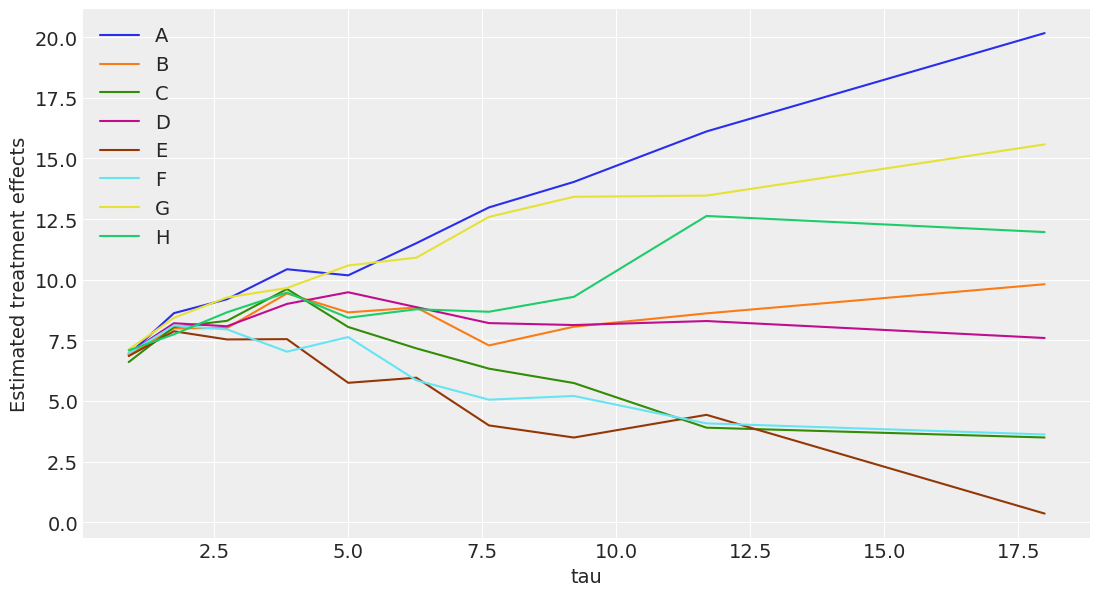

In [35]:
plt.figure(figsize=(13, 7))

for i, z in zip(range(post_trace_sample['theta'].shape[1]), 
                ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']):
    tau_post = post_trace_sample['tau']
    obs_post = post_trace_sample['theta'][:, i]

    # It is necessary to sort the list of pairs of points
    ll = sorted(list(zip(tau_post, obs_post)))
    x, y = partition_mean(ll, 100)
    plt.plot(x, y, label=z)

plt.xlabel('tau', fontsize=14)
plt.ylabel('Estimated treatment effects', fontsize=14)
plt.legend();

This plot is for the conditional posterior standard deviations of treatment effects, $\textrm{sd}\,(\theta_j \mid \tau, y)$, as functions of the between-school standard deviation $\tau$, for the educational testing example.

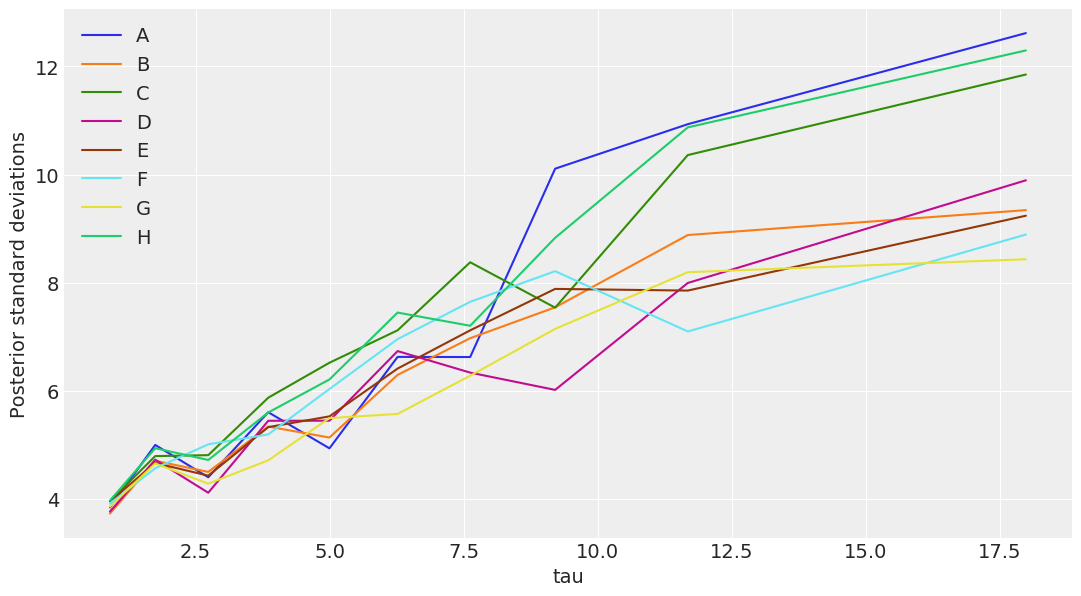

In [36]:
plt.figure(figsize=(13, 7))

for i, z in zip(range(post_trace_sample['theta'].shape[1]), 
                ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']):
    tau_post = post_trace_sample['tau']
    obs_post = post_trace_sample['theta'][:, i]

    # It is necessary to sort the list of pairs of points
    ll = sorted(list(zip(tau_post, obs_post)))
    x, y = partition_std(ll, 100)
    plt.plot(x, y, label=z)

plt.xlabel('tau', fontsize=14)
plt.ylabel('Posterior standard deviations', fontsize=14)
plt.legend();

We draw samples of `obs` from the posterior distribution.

In [37]:
with model_2:
    post_obs = pm.fast_sample_posterior_predictive(trace_2)

Reproducing the Table 5.3

In [38]:
print('{:^1} {:^50}'.format('School', 'Posterior quantiles'))
print('{:^7} {:^10} {:^10} {:^10} {:^10} {:^10}'.format(' ', '2.5%', '25%', 'median', '75%', '97.5%'))
print('-' * 70)

for i, z in zip(range(post_obs['obs'].shape[1]),
                ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']):
    
    a1 = np.percentile(post_obs['obs'][:, i], 2.5)
    a2 = np.percentile(post_obs['obs'][:, i], 25)
    a3 = np.percentile(post_obs['obs'][:, i], 50)
    a4 = np.percentile(post_obs['obs'][:, i], 75)
    a5 = np.percentile(post_obs['obs'][:, i], 97.5)
    print(f'{z:^7} {a1:^10.0f} {a2:^10.0f} {a3:^10.0f} {a4:^10.0f} {a5:^10.0f}')

School                Posterior quantiles                
           2.5%       25%       median      75%       97.5%   
----------------------------------------------------------------------
   A       -21         0          11         23         46    
   B       -15         0          8          16         31    
   C       -28         -5         7          18         41    
   D       -17         -1         8          16         33    
   E       -16         -2         6          13         26    
   F       -19         -2         7          15         31    
   G       -12         3          11         19         35    
   H       -30         -4         9          22         48    


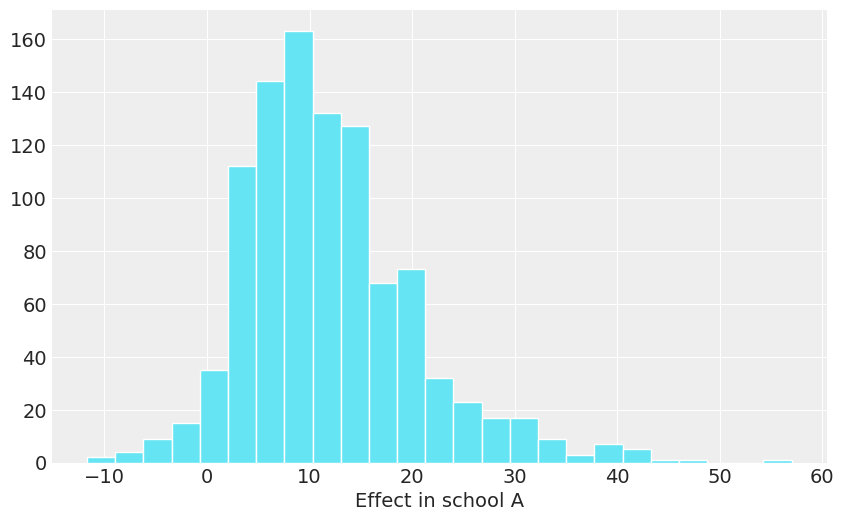

In [39]:
plt.figure(figsize=(10, 6))
_, _, _ = plt.hist(post_trace_sample['theta'][:, 0], color='C5', bins=25, edgecolor='w')
plt.xlabel('Effect in school A', fontsize=14);

In [40]:
max_theta = []

for i in range(200):
    with model_2:
        post_theta = pm.fast_sample_posterior_predictive(trace_2)
        max_theta.append(np.max(post_theta['obs'][:, :]))

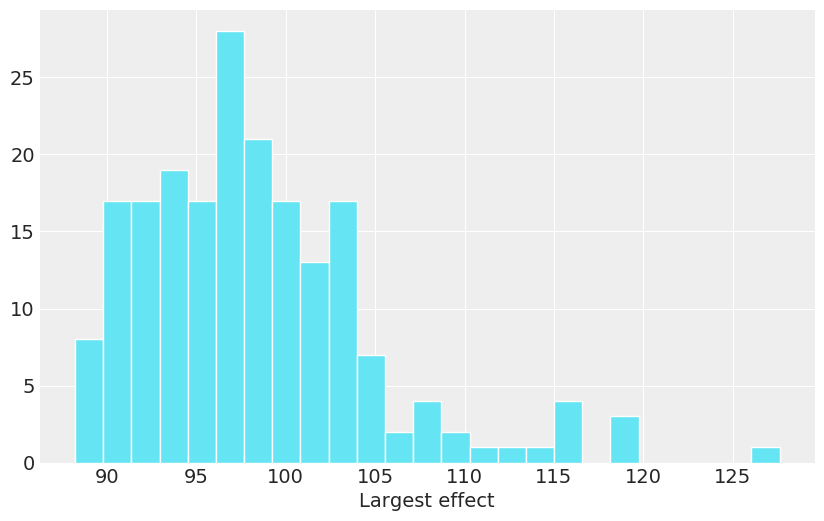

In [41]:
plt.figure(figsize=(10, 6))
_, _, _ = plt.hist(max_theta, color='C5', bins=25, edgecolor='w')
plt.xlabel('Largest effect', fontsize=14);

In [42]:
np.mean(np.array(max_theta) >= 28.4)

1.0

Ok, so the results are not quite good, I mean, there are a lot of discrepancies and the differences are notorious when you compare the two histograms previously showed with the Figure 5.8 (even more if you compare it with Table 5.3). Yes, the question is: Why does this happen? Is the algorithm behind `pymc3` the reason of all this? I would say that priors are really bad and the geometry behind the model is nasty. More info here: https://docs.pymc.io/notebooks/Diagnosing_biased_Inference_with_Divergences.html

Changing the prior of `tau_sq` to `inv-gamma(1, 1)`.

In [43]:
with pm.Model() as model_3:
    mu = pm.Uniform('mu', lower=0, upper=30)
    tau_sq = pm.InverseGamma('tau_sq', 1, 1)
    theta = pm.Normal('theta', mu=mu, sd=tau_sq, shape=yy.shape[0])
    obs = pm.Normal('obs', mu=theta, sd=sigma, observed=yy)

In [44]:
model_3.check_test_point()

mu_interval__    -1.39
tau_sq_log__     -1.31
theta            -1.81
obs             -31.29
Name: Log-probability of test_point, dtype: float64

In [45]:
with model_3:
    trace_3 = pm.sample(draws=5_000, tune=15_000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, tau_sq, mu]


Sampling 4 chains for 15_000 tune and 5_000 draw iterations (60_000 + 20_000 draws total) took 39 seconds.
There were 115 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6774626541804675, but should be close to 0.8. Try to increase the number of tuning steps.
There were 960 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5753121583539599, but should be close to 0.8. Try to increase the number of tuning steps.
There were 662 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5163645120303237, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1571 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.33250117427794107, but should be c

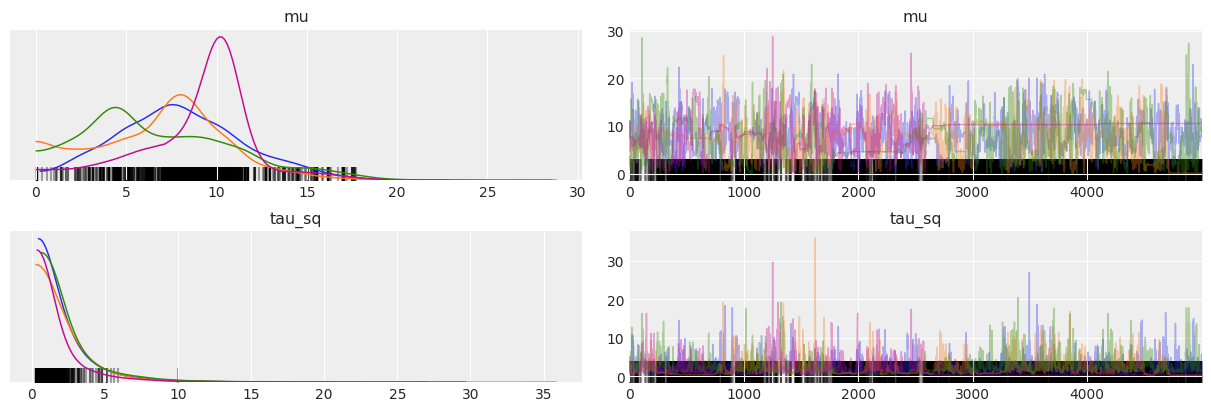

In [46]:
az.plot_trace(trace_3, var_names=['mu', 'tau_sq']);

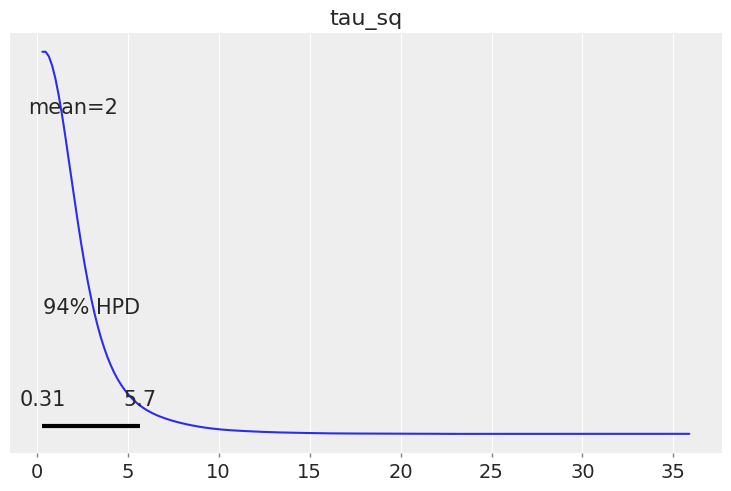

In [47]:
az.plot_posterior(trace_3, var_names=['tau_sq']);

Although this plot is similar to the Figure 5.9, they are not the same.

Changing the prior of `tau_sq` to `inv-gamma(0.001, 0.001)`.

In [48]:
with pm.Model() as model_4:
    mu = pm.Uniform('mu', lower=0, upper=30)
    tau_sq = pm.InverseGamma('tau_sq', 0.001, 0.001)
#     tau = pm.Deterministic('tau', pm.math.sqrt(tau_sq))
    theta = pm.Normal('theta', mu=mu, sd=tau_sq, shape=yy.shape[0])
    obs = pm.Normal('obs', mu=theta, sd=sigma, observed=yy)

In [49]:
with model_4:
    # had to modify the init to adapt_diag to avoid an error with bad values on the diagonal
    trace_4 = pm.sample(draws=5_000, tune=15_000, chains=2, init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [theta, tau_sq, mu]


Sampling 2 chains for 15_000 tune and 5_000 draw iterations (30_000 + 10_000 draws total) took 36 seconds.
There were 456 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6167390971209142, but should be close to 0.8. Try to increase the number of tuning steps.
There were 334 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6314393936668119, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


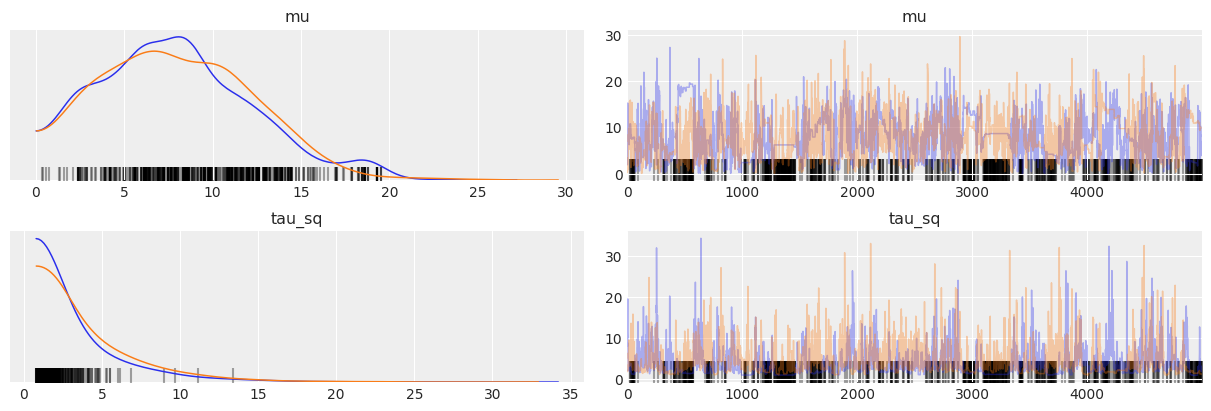

In [50]:
az.plot_trace(trace_4, var_names=['mu', 'tau_sq']);

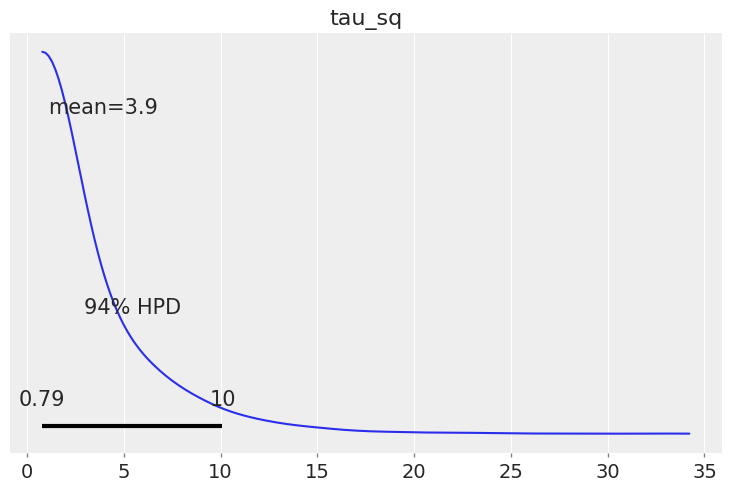

In [51]:
az.plot_posterior(trace_4, var_names=['tau_sq']);

Again, although this plot is similar to the Figure 5.9, they are not the same.

Changing the prior of `tau_sq` to half-Cauchy. This time, the data are the first three schools.

In [52]:
with pm.Model() as model_5:
    mu = pm.Uniform('mu', lower=0, upper=30)
    tau_sq = pm.HalfCauchy('tau_sq', 25)
    theta = pm.Normal('theta', mu=mu, sd=tau_sq, shape=yy[:3].shape[0])
    obs = pm.Normal('obs', mu=theta, sd=sigma[:3], observed=yy[:3])

In [53]:
with model_5:
    trace_5 = pm.sample(draws=5000, tune=10_000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, tau_sq, mu]


Sampling 4 chains for 10_000 tune and 5_000 draw iterations (40_000 + 20_000 draws total) took 17 seconds.
There were 179 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7172951992815328, but should be close to 0.8. Try to increase the number of tuning steps.
There were 184 divergences after tuning. Increase `target_accept` or reparameterize.
There were 194 divergences after tuning. Increase `target_accept` or reparameterize.
There were 255 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6827210848060099, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


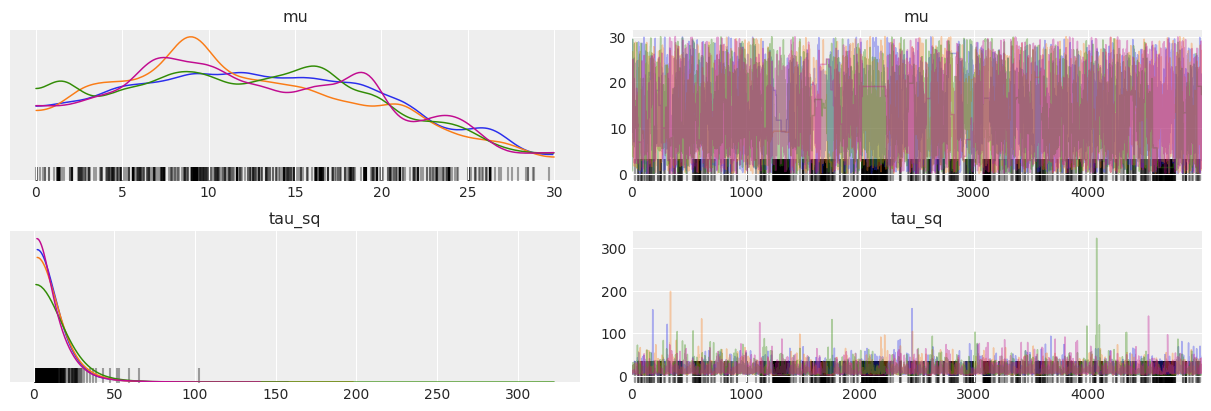

In [54]:
az.plot_trace(trace_5, var_names=['mu', 'tau_sq']);

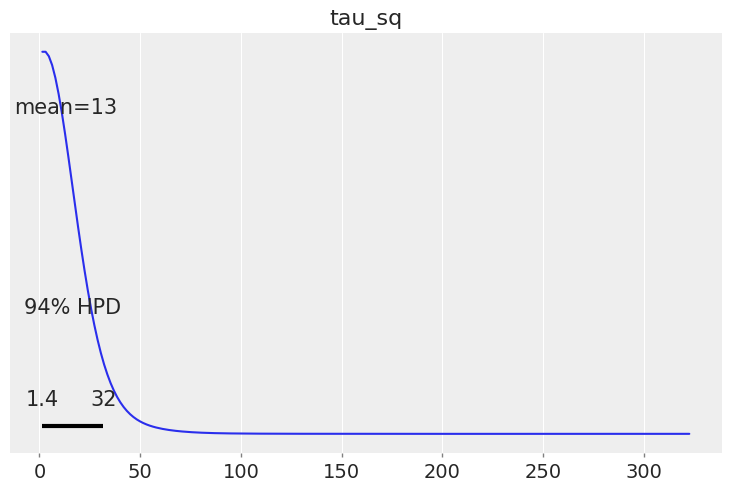

In [55]:
az.plot_posterior(trace_5, var_names=['tau_sq']);

Changing the prior of `tau_sq`. And the data are the first three schools.

In [56]:
with pm.Model() as model_6:
    mu = pm.Uniform('mu', lower=0, upper=30)
    tau_sq = pm.Uniform('tau_sq', lower=0, upper=100_000)
    theta = pm.Normal('theta', mu=mu, sd=tau_sq, shape=yy[:3].shape[0])
    obs = pm.Normal('obs', mu=theta, sd=sigma[:3], observed=yy[:3])

In [57]:
with model_6:
    trace_6 = pm.sample(draws=7_000, tune=10_000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [theta, tau_sq, mu]


Sampling 2 chains for 10_000 tune and 7_000 draw iterations (20_000 + 14_000 draws total) took 17 seconds.
There were 195 divergences after tuning. Increase `target_accept` or reparameterize.
There were 444 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6935077098234447, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


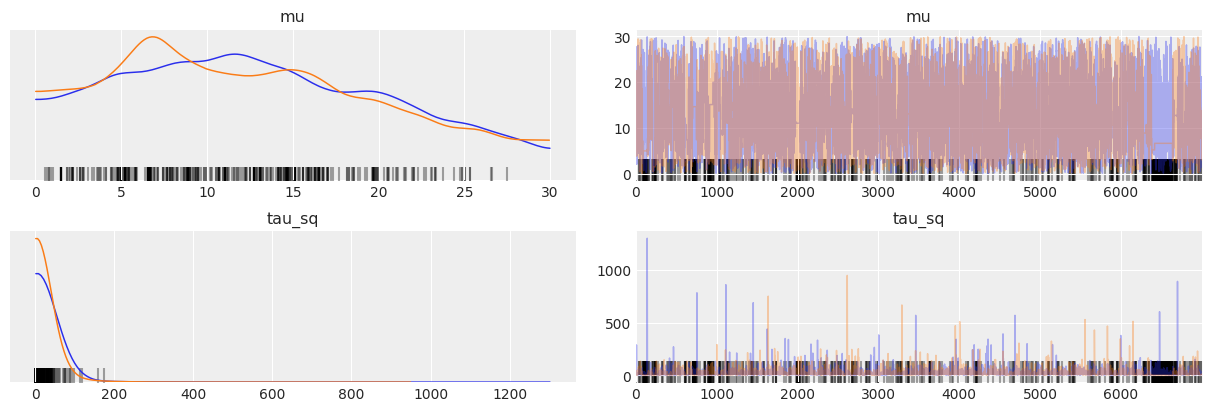

In [58]:
az.plot_trace(trace_6, var_names=['mu', 'tau_sq']);

In [59]:
az.plot_posterior(trace_6, var_names=['tau_sq'], ax=ax)

In [60]:
%watermark -iv -v -p theano,scipy,matplotlib,arviz -m

pymc3      3.8
matplotlib 3.1.3
arviz      0.7.0
numpy      1.18.1
CPython 3.6.8
IPython 7.12.0

theano 1.0.4
scipy 1.4.1
matplotlib 3.1.3
arviz 0.7.0

compiler   : GCC 4.2.1 Compatible Apple LLVM 10.0.1 (clang-1001.0.46.4)
system     : Darwin
release    : 19.4.0
machine    : x86_64
processor  : i386
CPU cores  : 16
interpreter: 64bit
